# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otocznia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

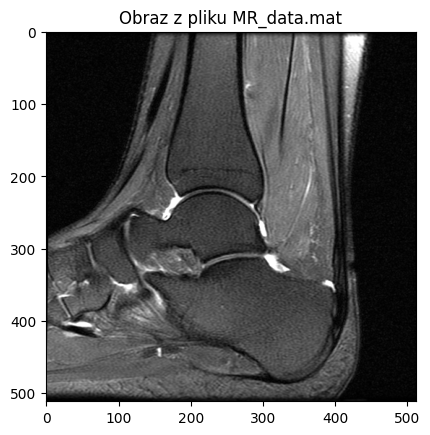

In [14]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)

mat = loadmat('MR_data.mat')

input_image = mat['I_noisy4']

plt.imshow(input_image, cmap='gray')
plt.title('Obraz z pliku MR_data.mat')
plt.show()


### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

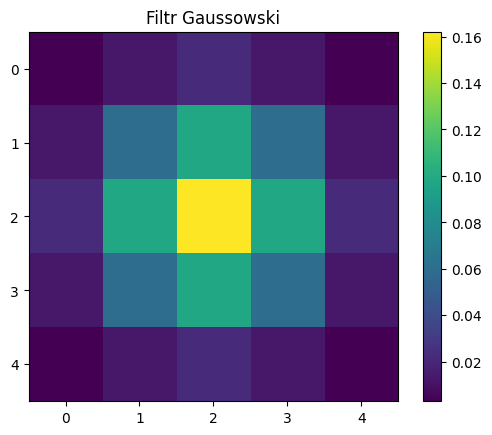

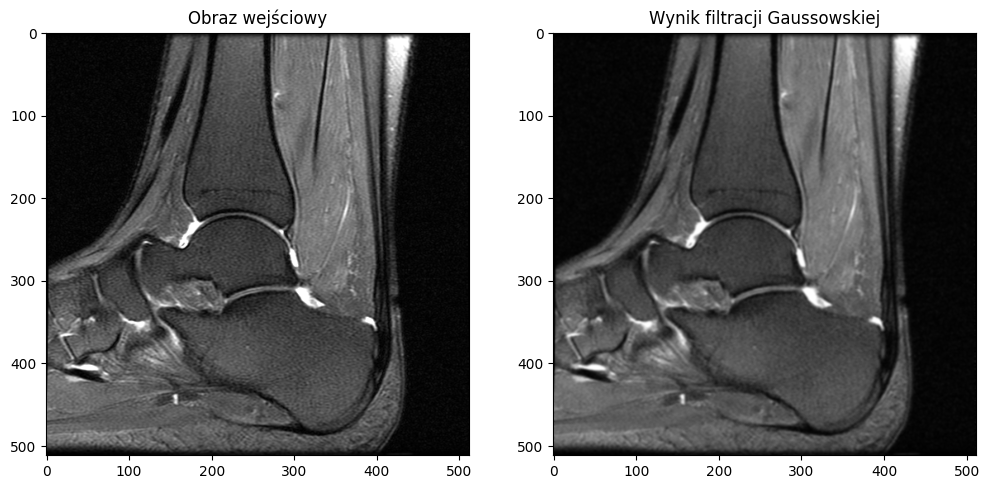

In [15]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

# Zdefiniuj parametry filtra Gaussowskiego
window_size = 5
delta_S = 1.0

# Oblicz współczynniki filtra Gaussowskiego
x, y = np.meshgrid(np.arange(-window_size//2 + 1, window_size//2 + 1),
                   np.arange(-window_size//2 + 1, window_size//2 + 1))
gaussian_filter = np.exp(-(x**2 + y**2) / (2.0 * delta_S**2))
gaussian_filter /= np.sum(gaussian_filter)  # Normalizacja

# Zwizualizuj filtr
plt.imshow(gaussian_filter, cmap='viridis')
plt.title('Filtr Gaussowski')
plt.colorbar()
plt.show()

# Skopiuj obraz wejściowy
IConv = input_image.copy()

# Funkcja do obliczania nowej wartości piksela
def apply_gaussian_filter(window, filter_coefficients):
    return np.sum(window * filter_coefficients)

# Filtracja obrazu
for i in range(window_size//2, input_image.shape[0] - window_size//2):
    for j in range(window_size//2, input_image.shape[1] - window_size//2):
        # Tworzenie aktualnego kontekstu
        window = input_image[i - window_size//2:i + window_size//2 + 1,
                             j - window_size//2:j + window_size//2 + 1]

        # Obliczanie nowej wartości piksela
        new_pixel_value = apply_gaussian_filter(window, gaussian_filter)

        # Przypisanie wartości do piksela w kopii obrazu wejściowego
        IConv[i, j] = new_pixel_value

# Wyświetlenie wyniku filtracji
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Obraz wejściowy')
plt.subplot(1, 2, 2)
plt.imshow(IConv, cmap='gray')
plt.title('Wynik filtracji Gaussowskiej')
plt.show()




### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

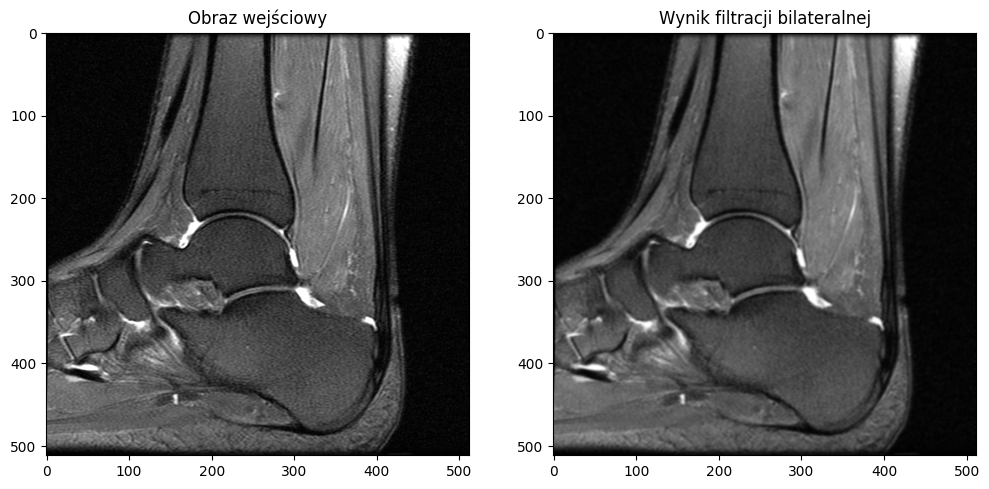

In [16]:
import numpy as np
from scipy.ndimage import convolve
import matplotlib.pyplot as plt

# Zdefiniuj dodatkowy parametr: wariancję δ_R
delta_R = 50.0

# Skopiuj obraz wejściowy
IBilateral = input_image.copy()

# Funkcja do obliczania nowej wartości piksela w filtracji bilateralnej
def apply_bilateral_filter(window, spatial_filter, delta_R):
    center_pixel = window[window.shape[0] // 2, window.shape[1] // 2]

    # Oblicz odległość w przeciwdziedzinie (dla wartości pikseli)
    intensity_difference = window - center_pixel

    # Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem delta_R
    range_filter = np.exp(-(intensity_difference**2) / (2 * delta_R**2))

    # Oblicz iloczyn punktowy filtrów przestrzennego i przeciwdziedzinowego
    combined_filter = spatial_filter * range_filter

    # Wykonaj normalizację obliczonych współczynników
    combined_filter /= np.sum(combined_filter)

    # Oblicz nową wartość piksela
    new_pixel_value = np.sum(combined_filter * window)

    return new_pixel_value

# Filtracja obrazu bilateralna
for i in range(window_size//2, input_image.shape[0] - window_size//2):
    for j in range(window_size//2, input_image.shape[1] - window_size//2):
        # Tworzenie aktualnego kontekstu
        window = input_image[i - window_size//2:i + window_size//2 + 1,
                             j - window_size//2:j + window_size//2 + 1]

        # Obliczanie nowej wartości piksela
        new_pixel_value = apply_bilateral_filter(window, gaussian_filter, delta_R)

        # Przypisanie wartości do piksela w kopii obrazu wejściowego
        IBilateral[i, j] = new_pixel_value

# Wyświetlenie wyniku filtracji bilateralnej
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Obraz wejściowy')
plt.subplot(1, 2, 2)
plt.imshow(IBilateral, cmap='gray')
plt.title('Wynik filtracji bilateralnej')
plt.show()

